In [3]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./MNIST_data/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


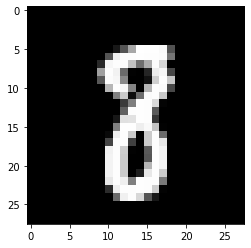

In [5]:
img = mnist.train.images[50]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

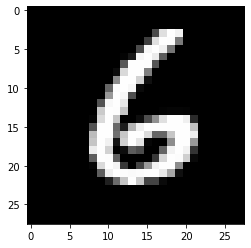

In [6]:
img = mnist.train.images[1000]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [8]:
def get_inputs(real_size, noise_size):
    """
    真实图像tensor与噪声图像tensor
    """
    real_img = tf.placeholder(tf.float32, [None, real_size], name='real_img')
    noise_img = tf.placeholder(tf.float32, [None, noise_size], name='noise_img')
    
    return real_img, noise_img

In [9]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
    """
    生成器：
    noise_img: 生成器的输入
    n_units: 隐层单元个数
    out_dim: 生成器输出tensor的size，这里应该为32*32=784
    alpha: leaky ReLU系数
    """
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

In [10]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):
    """
    判别器：
    n_units: 隐层结点数量
    alpha: Leaky ReLU系数
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

In [11]:
# 定义参数
img_size = mnist.train.images[0].shape[0]  # 真实图像的size
noise_size = 100  # 传入给generator的噪声size
g_units = 128  # 生成器隐层参数
d_units = 128  # 判别器隐层参数
alpha = 0.01  # leaky ReLU的参数
learning_rate = 0.001  # learning_rate
smooth = 0.1  # label smoothing

In [12]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.


In [13]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)) * (1 - smooth))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)) * (1 - smooth))

In [14]:
train_vars = tf.trainable_variables()

# generator中的tensor
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator中的tensor
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [15]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
                        
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}(Real: {:.4f} + Fake: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        
        # 记录各类loss值
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
                # 抽取样本后期进行观察
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        # 存储checkpoints
        saver.save(sess, './checkpoints/generator.ckpt')

# 将sample的生成数据记录下来
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... Discriminator Loss: 0.0404(Real: 0.0070 + Fake: 0.0334)... Generator Loss: 3.5882
Epoch 2/300... Discriminator Loss: 0.8070(Real: 0.1906 + Fake: 0.6164)... Generator Loss: 2.9891
Epoch 3/300... Discriminator Loss: 0.2562(Real: 0.1328 + Fake: 0.1235)... Generator Loss: 2.6456
Epoch 4/300... Discriminator Loss: 2.2687(Real: 1.2904 + Fake: 0.9783)... Generator Loss: 0.9097
Epoch 5/300... Discriminator Loss: 3.6088(Real: 1.9477 + Fake: 1.6611)... Generator Loss: 0.3891
Epoch 6/300... Discriminator Loss: 1.3190(Real: 0.7257 + Fake: 0.5933)... Generator Loss: 2.1852
Epoch 7/300... Discriminator Loss: 2.2046(Real: 1.0590 + Fake: 1.1456)... Generator Loss: 1.6815
Epoch 8/300... Discriminator Loss: 1.8929(Real: 1.2023 + Fake: 0.6906)... Generator Loss: 0.9081
Epoch 9/300... Discriminator Loss: 2.3139(Real: 1.2413 + Fake: 1.0726)... Generator Loss: 0.8651
Epoch 10/300... Discriminator Loss: 1.0061(Real: 0.5319 + Fake: 0.4742)... Generator Loss: 1.5568
Epoch 11/300... Discriminator

Epoch 85/300... Discriminator Loss: 0.9751(Real: 0.5065 + Fake: 0.4686)... Generator Loss: 1.3501
Epoch 86/300... Discriminator Loss: 0.9410(Real: 0.3597 + Fake: 0.5813)... Generator Loss: 1.1629
Epoch 87/300... Discriminator Loss: 0.7940(Real: 0.3741 + Fake: 0.4199)... Generator Loss: 1.3515
Epoch 88/300... Discriminator Loss: 1.0366(Real: 0.4699 + Fake: 0.5667)... Generator Loss: 1.1488
Epoch 89/300... Discriminator Loss: 0.8338(Real: 0.4389 + Fake: 0.3949)... Generator Loss: 1.3822
Epoch 90/300... Discriminator Loss: 0.8732(Real: 0.4056 + Fake: 0.4676)... Generator Loss: 1.2679
Epoch 91/300... Discriminator Loss: 0.8077(Real: 0.4502 + Fake: 0.3575)... Generator Loss: 1.6035
Epoch 92/300... Discriminator Loss: 1.0577(Real: 0.6343 + Fake: 0.4235)... Generator Loss: 1.4239
Epoch 93/300... Discriminator Loss: 0.9882(Real: 0.4552 + Fake: 0.5330)... Generator Loss: 1.1375
Epoch 94/300... Discriminator Loss: 0.8795(Real: 0.4527 + Fake: 0.4269)... Generator Loss: 1.4393
Epoch 95/300... Disc

Epoch 168/300... Discriminator Loss: 0.9447(Real: 0.4197 + Fake: 0.5250)... Generator Loss: 1.3606
Epoch 169/300... Discriminator Loss: 0.8884(Real: 0.3074 + Fake: 0.5810)... Generator Loss: 1.3451
Epoch 170/300... Discriminator Loss: 0.8785(Real: 0.5265 + Fake: 0.3520)... Generator Loss: 1.7005
Epoch 171/300... Discriminator Loss: 0.8872(Real: 0.3909 + Fake: 0.4962)... Generator Loss: 1.4419
Epoch 172/300... Discriminator Loss: 1.0430(Real: 0.6557 + Fake: 0.3873)... Generator Loss: 1.6484
Epoch 173/300... Discriminator Loss: 0.9853(Real: 0.5545 + Fake: 0.4307)... Generator Loss: 1.5705
Epoch 174/300... Discriminator Loss: 0.7536(Real: 0.3905 + Fake: 0.3630)... Generator Loss: 1.5703
Epoch 175/300... Discriminator Loss: 0.8670(Real: 0.4878 + Fake: 0.3792)... Generator Loss: 1.5328
Epoch 176/300... Discriminator Loss: 0.9766(Real: 0.3494 + Fake: 0.6272)... Generator Loss: 1.1368
Epoch 177/300... Discriminator Loss: 0.9525(Real: 0.5773 + Fake: 0.3751)... Generator Loss: 1.7274
Epoch 178/

Epoch 251/300... Discriminator Loss: 0.8089(Real: 0.3981 + Fake: 0.4108)... Generator Loss: 1.5438
Epoch 252/300... Discriminator Loss: 0.7921(Real: 0.4870 + Fake: 0.3050)... Generator Loss: 1.8868
Epoch 253/300... Discriminator Loss: 0.6571(Real: 0.3461 + Fake: 0.3109)... Generator Loss: 1.9374
Epoch 254/300... Discriminator Loss: 0.8849(Real: 0.5280 + Fake: 0.3569)... Generator Loss: 1.6637
Epoch 255/300... Discriminator Loss: 0.8141(Real: 0.3768 + Fake: 0.4373)... Generator Loss: 1.5321
Epoch 256/300... Discriminator Loss: 0.8834(Real: 0.4831 + Fake: 0.4003)... Generator Loss: 1.5416
Epoch 257/300... Discriminator Loss: 0.9576(Real: 0.3660 + Fake: 0.5915)... Generator Loss: 1.5052
Epoch 258/300... Discriminator Loss: 0.7620(Real: 0.4597 + Fake: 0.3022)... Generator Loss: 1.8124
Epoch 259/300... Discriminator Loss: 0.9700(Real: 0.3743 + Fake: 0.5957)... Generator Loss: 1.3038
Epoch 260/300... Discriminator Loss: 0.9045(Real: 0.4735 + Fake: 0.4310)... Generator Loss: 1.6809
Epoch 261/

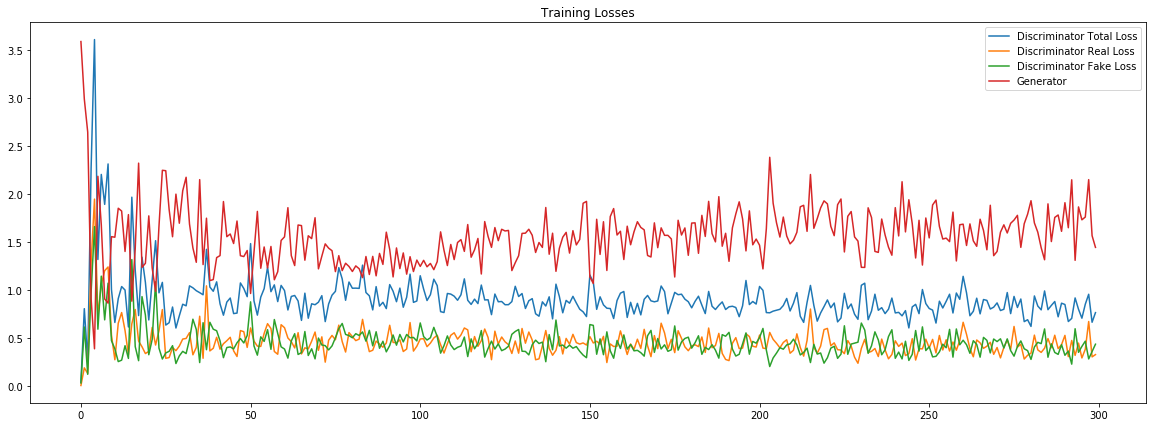

In [16]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator Total Loss')
plt.plot(losses.T[1], label='Discriminator Real Loss')
plt.plot(losses.T[2], label='Discriminator Fake Loss')
plt.plot(losses.T[3], label='Generator')
plt.title("Training Losses")
plt.legend()

In [17]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [18]:
def view_samples(epoch, samples):
    """
    epoch代表第几次迭代的图像
    samples为我们的采样结果
    """
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]): # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

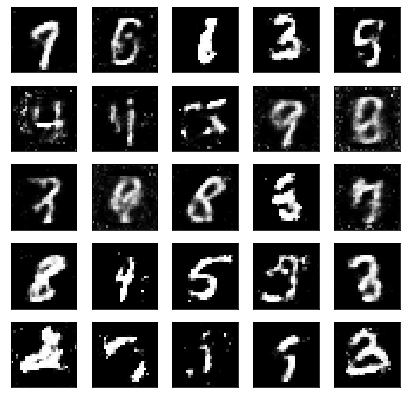

In [19]:
_ = view_samples(-1, samples) # 显示最后一轮的outputs

In [20]:
# 指定要查看的轮次
epoch_idx = []
for i in range(0, 300 ,5):
    epoch_idx.append(i) # 一共300轮，不要越界
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

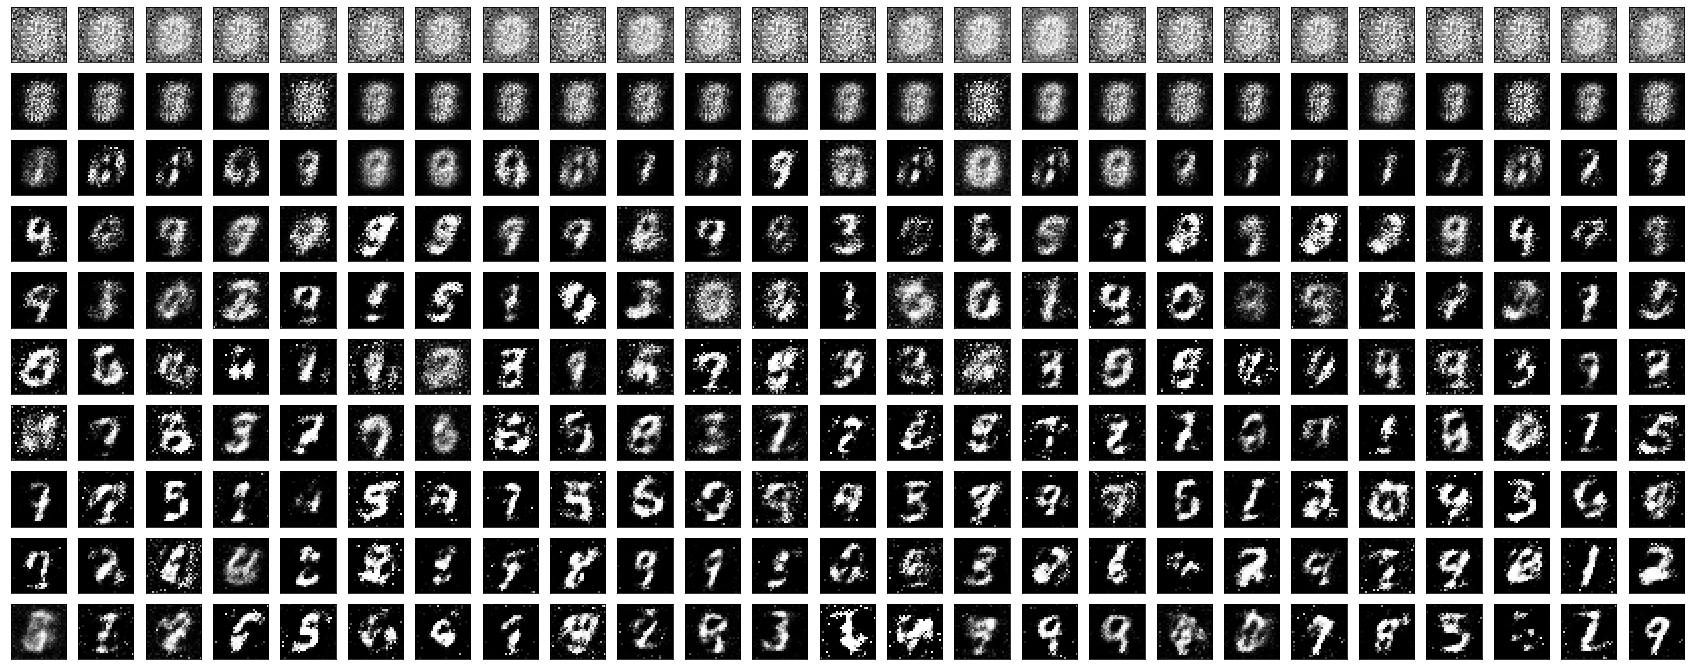

In [21]:
# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

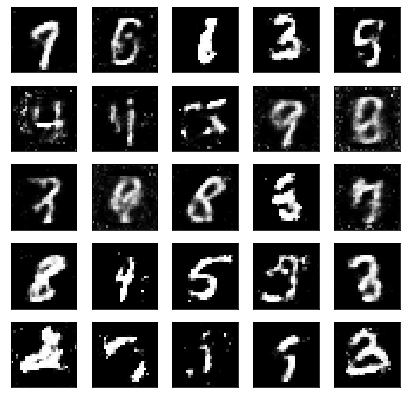

In [22]:
_ = view_samples(0, [gen_samples])